# Supervised Learning Approach

Supervised Learning is a practical Machine Learning approach where a model is trained to learn the relationship between an input and an output. In supervised learning we first start with a data set containing training examples with associated correct labels. In our case, this is the stock data that we are using. Our supervised learning takes in hundreds of values of stock pricing for a given day, and is then trained to learn the relationship between stock price per day. More formally, we’d like our model to approximate the relationship, lets call it f, between the number of days X and corresponding to stock price.

In our approach, there are two main factors we consider. The first is analyzing future profitability on the basis of current performance. (i.e. given our current earnings, how can we decide to buy and or sell?). Secondly, how can we use a statistical analysis to identify trends of the market and make beneficial predictions for the next day.

## Supervised Learning Approach

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 30
BATCH_SIZE = 30

### Reading Stock Data

We start by reading five major stocks, Microsft, Google,  Amazon, IBM, and Apple.

In [38]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")
googl = pd.read_csv("./Individual_Stock_Data/GOOGL.csv")
amzn = pd.read_csv("./Individual_Stock_Data/AMZN.csv")
ibm = pd.read_csv("./Individual_Stock_Data/IBM.csv")
aapl = pd.read_csv("./Individual_Stock_Data/AAPL.csv")

In [39]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


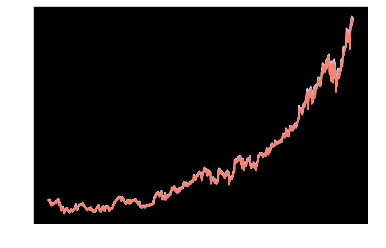

In [40]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

Normlaizing the data simply helps the algorithm in converging i.e. to find local/ global minimum efficiently, for future predictions. Before fully normalizing the data, we also split the dataset into training and testing data sets. As expected, the training dataset is used to train the model, and the testing dataset is used to observe the performance of the model after the training.


In [41]:
df_train, df_test = train_test_split(msft, train_size=0.84, test_size=0.16, shuffle=False)

In [42]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [43]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2009,2017-12-26,85.31,85.53,85.03,85.40,83.28,9891200
2010,2017-12-27,85.65,85.98,85.22,85.71,83.58,14678000
2011,2017-12-28,85.90,85.93,85.55,85.72,83.59,10594300
2012,2017-12-29,85.63,86.05,85.50,85.54,83.42,18717400
2013,2018-01-02,86.13,86.31,85.50,85.95,83.82,22483800


### Training and Testing the Data. 

As part of the normalization mentioned earlier, we transofrm the data, intialize th emodel, and train and test the model. We run the function here but each major part is broken down in the following parts.


In [44]:
def train_and_test(data, stock_name="", load_model=False):
    df_train, df_test = train_test_split(data, train_size=0.84, test_size=0.16, shuffle=False)
    
    train_cols = ["Open", "High", "Low", "Adj Close", "Volume"]
    print("Train and Test Size:", len(df_train), len(df_test))
    x = df_train.loc[:,train_cols].values
    min_max_scaler = MinMaxScaler()
    
    # Transforming Data
    x_train = min_max_scaler.fit_transform(x)
    x_test = min_max_scaler.transform(df_test.loc[:,train_cols])
    print(df_train[train_cols])

    

    def build_timeseries(mat, y_col_index):
        # y_col_index is the index of column that would act as output column
        # total number of time-series samples would be len(mat) - TIME_STEPS
        dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
        x = np.zeros((dim_0, TIME_STEPS, dim_1))
        y = np.zeros((dim_0,))
        for i in range(dim_0):
            x[i] = mat[i:TIME_STEPS+i]
            y[i] = mat[TIME_STEPS+i, y_col_index]
        print("length of time-series i/o",x.shape,y.shape)
        return x, y

    def trim_dataset(mat, batch_size):
        """
        trims dataset to a size that's divisible by BATCH_SIZE
        """
        no_of_rows_drop = mat.shape[0]%batch_size
        if(no_of_rows_drop > 0):
            return mat[:-no_of_rows_drop]
        else:
            return mat

    x_t, y_t = build_timeseries(x_train, 3)
    x_t = trim_dataset(x_t, BATCH_SIZE)
    y_t = trim_dataset(y_t, BATCH_SIZE)
    x_temp, y_temp = build_timeseries(x_test, 3)
    x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
    y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
    # print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(40,activation='relu')) # 40
    lstm_model.add(Dense(1,activation='sigmoid')) # 
    optimizer = optimizers.RMSprop(lr=0.001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    csv_logger = CSVLogger("stock_supervised.log", append=True)

    history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                            shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                            trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
    
    lstm_model.save("SL_stock_model.h5")
    
    from keras.models import load_model

    y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
    y_pred = y_pred.flatten()
    y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
    error = mean_squared_error(y_test_t, y_pred)
    #print("Error is", error, y_pred.shape, y_test_t.shape)

    # convert the predicted value to range of real data
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
    
    plt.figure()
    plt.plot(y_pred_org)
    plt.plot(y_test_t_org)
    plt.title('Prediction vs Real Stock Price ' + stock_name)
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'], loc='upper left')
    plt.savefig('pred_vs_real_BS_'+stock_name+'.png')

    plt.show()

    return y_test_t_org, y_pred_org

In [45]:
x_train.shape, x_test.shape


NameError: name 'x_train' is not defined

## Build Time-Series Structure

One of the most improtant aspects of creating an effective model is the actual algorithm we use. Here, we are using an LSTM model specifically for its well-suitment to process and predict time series given values that change over an unkown period of time. 

LSTMs consume input in format of a three-dimensional array; [ batch_size, time_steps, Features ]

Batch Size is a number representing the number of samples of data the nueral net should see before re-adjusting and updating weights. 

The Time Steps basically define how many units back in time you want your network to see.


Features is the number of attributes used to represent each time step.

We label these parameters in the initializtion of the project.









### Converting Data to Time Series
In this step, our goal is to convert our data into a format to pass into our model. We want our model to look back on our 'time_step' amount of days and want to represent our data set accordingly.

### Trimming the Dataset
After converting our data, we also want to trim the data to remove any excess odd samples. For example, if we have 51 samples and our batchsize is 25, we would need to trim the excess sample data.

### Forming Datasets
In this step, we simply form our train, validation and test datasets

In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)


In [0]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [0]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE, #50
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
lstm_model.save("SL_stock_model.h5")

### Creating, Training, and Testing the Model

Here, we initialize the LSTM Model and train it using our datasets. Then we test it on our test dataset and plot its prediction trajectory.

In [0]:
from keras.models import load_model

y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

print(y_pred_org[0:15])
print(y_test_t_org[0:15])

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
plt.show()
plt.savefig('pred_vs_real_BS_.png')


### Judging How Effective Our Model Is

In the following sections, we plot and detail the performance of our model. We also discuss the changes introduced by shifting the value of episolon or the threshhold for our model to buy or sell.

In [0]:
from keras import backend as K

def coeff_determination(y_true, y_pred):

    SS_res =K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

R_2 = coeff_determination(y_test_t_org, y_pred_org)
with tf.Session() as sess:  
    print(R_2.eval()) 


In [0]:
y_pred = y_pred_org
y = y_test_t_org
positions = [y[0]]
profits = []
max_len_p = 0
eps = 0.02 # Vary this between 0.01 and 0.05 to maximize profit
epsilons = np.arange(0, 0.05, .001)
max_pos = []
for eps in epsilons:
    profit= 0
    for t in range(1,len(y)):
        if y_pred[t] > y[t-1] + eps*y[t-1]:
            positions.append(y[t])
        elif y_pred[t] < y[t-1] - eps*y[t-1]:
            for p in positions:
                profit += (y[t] - p)
            positions = []
        max_len_p = max(max_len_p, len(positions))
    profits.append(profit)
    max_pos.append(max_len_p)

plt.figure()
plt.plot(epsilons, profits)
plt.title('Profit maximization')
plt.ylabel('Profits')
plt.xlabel('Epsilon')
plt.legend(['Profits', 'Epsilon'], loc='upper left')
plt.show()
print("Max Profits:", max(profits))

### Note on Changing Epsilon Values
If we change the epsilon value, we essentially change the range we can choose whether or not to buy or sell at, rather than hold. From these results, we can see that our maximum epsilon value is around 0.02, so we buy a stock when our predicted price is more than 2% higher than what it was the day before, and we sell if our maximum epsilon value is around 2% lower.  

In [0]:
msft_y, msft_y_pred = train_and_test(msft, "MSFT")
googl_y, googl_y_pred = train_and_test(googl, "GOOGL")
amzn_y, amzn_y_pred = train_and_test(amzn, "AMZN")
ibm_y, ibm_y_pred = train_and_test(ibm, "IBM")
aapl_y, aapl_y_pred = train_and_test(aapl, "AAPL")